<a href="https://colab.research.google.com/github/salu133445/flows/blob/main/realnvp_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RealNVP on Toy Dataset

Code adapted from https://github.com/tensorchiefs/dl_book.

## RealNVP Example

__Goal__: This notebook shows how to wrap learnable flows into Keras _subclassing_ `tf.keras.models.Model`. 

__Usage__: Try to understand the provided code.

__Dataset__: Two dimnesional artifical data.

__Content__:
- Generation of the 2 dimensional artificial data set
- Creating a RealVNP-Flow subclassing Keras
- Fitting the flow to the 2-dimensional data

In [1]:
!pip install --upgrade tensorflow tensorflow_probability

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
     |████████████████████████████████| 4.8MB 15.5MB/s 
  Found existing installation: tensorflow-probability 0.11.0
    Uninstalling tensorflow-probability-0.11.0:
      Successfully uninstalled tensorflow-probability-0.11.0


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(1)
tf.random.set_seed(1)

### Learning Flows with TF 2.0

Let's create a flow using parameters, which can be learned. We use masked Autoregressive flows for that. 

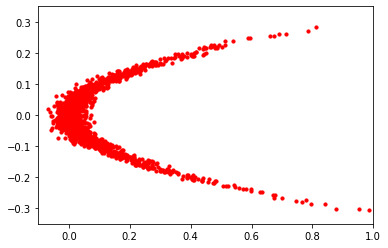

In [3]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') #A real hard problem

# Adapted from: https://blog.evjang.com/2018/01/nf1.html
def sample_2(batch_size=500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=tf.float32))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy()/40.0

X = sample_2(1500)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

### Makeing a Keras model

#### Subclassing a Keras model

We build our own model. As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`. Having the variables in a model. Keras takes care of holding the variables.

#### Listing 6.7: The simple example of realNVPn TFP

Note that the listing in the book just shows the inner part.

In [4]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
import time
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.nets=[]
        
        # We need to keep track of the nets
        bijectors=[]
        num_blocks = 5
        h = 32 
        for i in range(num_blocks): 
            net = tfb.real_nvp_default_template([h, h])
            bijectors.append(
                tfb.RealNVP(shift_and_log_scale_fn=net, 
                            num_masked=num_masked))
            bijectors.append(tfb.Permute([1,0])) 
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))

        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    

model = RealNVP(output_dim=2, num_masked=1)
_ = model(X) # The model needs called before it is build.
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Model: "real_nvp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

@tf.function
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time.time()
for i in range(1001):
    # Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time.time()-start))
        start = time.time()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


0   1.8581398 2.2348289489746094
100   -2.3694506 0.42362165451049805
200   -3.1232886 0.41953253746032715
300   -3.153249 0.45066022872924805
400   -3.160012 0.4218137264251709
500   -3.1645117 0.4132578372955322
600   -3.163457 0.4162752628326416
700   -3.1683323 0.41474175453186035
800   -3.1674402 0.42066073417663574
900   -3.1632428 0.4221010208129883
1000   -3.166689 0.4377741813659668


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


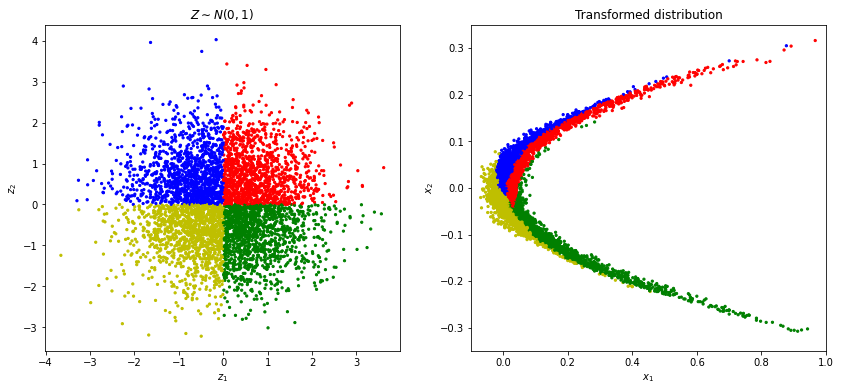

In [6]:
# XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

### Understanding the mixture

We redo the morphing between two point in the x-space. In our high dimensional examples, we went from Beyonce to DiCaprio. We now redo this morphing with the two dimensional example to understand the principle.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Pleas

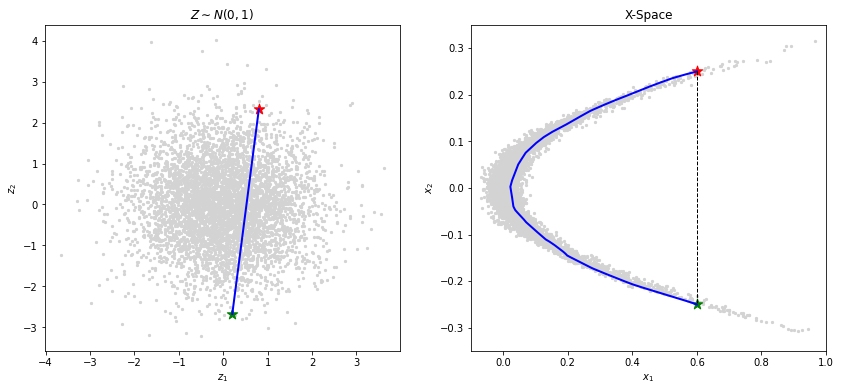

In [7]:
X1 = np.array((0.6, 0.25), dtype=np.float32)
X2 = np.array((0.6, -0.25), dtype=np.float32)

Z1 = model.flow.bijector.inverse(X1)  # np.array((-1.5,-1.5), dtype=float32)
Z2 = model.flow.bijector.inverse(X2)  # np.array((1.5,1.5), dtype=float32)

nums = 500
Z_mixs = np.zeros((nums,2),dtype=np.float32)
for i,m in enumerate(np.linspace(0,1,nums)):
    Z_mixs[i] = (Z2*m+Z1*(1.-m))
    
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c='lightgray')
plt.plot(Z_mixs[:,0],Z_mixs[:,1],c='blue', linewidth=2)
plt.scatter(Z_mixs[0,0],Z_mixs[0,1],c='red', s=120,marker='*')
plt.scatter(Z_mixs[nums-1,0],Z_mixs[nums-1,1],c='green', s=120,marker='*')

plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.subplot(1,2,2)
plt.title('X-Space')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5,c='lightgray')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.scatter(X1[0], X1[1], s=10)
plt.scatter(X2[0], X2[1], s=10)
X_mix = model.flow.bijector.forward(Z_mixs)
plt.plot(X_mix[:,0],X_mix[:,1],c='blue',linewidth=2)
plt.scatter(X1[0],X1[1],c='red', s=120,marker='*')
plt.scatter(X2[0],X2[1],c='green', s=120,marker='*')

X_mixs = np.zeros((nums,2), dtype=np.float32)
for i,m in enumerate(np.linspace(0,1,nums)):
    X_mixs[i] = (X2*m+X1*(1.-m))
plt.plot(X_mixs[:,0],X_mixs[:,1],'--',c='black', linewidth=1.)
plt.show()